In [1]:
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from gymnax.environments import spaces
from typing import Optional

from experior.utils import PRNGSequence, moving_average
from experior.envs import BayesStochasticBandit
from experior.bandit_agents import (
  make_thompson_sampling,
  make_max_ent_thompson_sampling,
  make_bernoulli_thompson_sampling,
  LinearDiscreteRewardModel
)
from experior.experts import generate_optimal_trajectories

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')



jax.config.update("jax_debug_nans", True)
%load_ext autoreload
%autoreload 2


In [2]:
! nvidia-smi

Wed Jan 24 20:42:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:D8:00.0 Off |                    0 |
|  0%   38C    P0    56W / 300W |      0MiB / 45634MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameter Search - Thompson Sampling

In [3]:
NUM_ACTIONS = 5
NUM_STEPS = 1024
NUM_ENVS = 50
SEED = 42

# bernoulli bandit setup
action_space = spaces.Discrete(NUM_ACTIONS)
prior_function = jax.tree_util.Partial(lambda key, _: jax.random.uniform(key, shape=(NUM_ACTIONS,))) # uniform prior
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]).astype(jnp.float32))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
reward_mean_fn = jax.tree_util.Partial(lambda means, _, action: means[action])
mutli_armed_bandit = BayesStochasticBandit(action_space, prior_function, reward_dist_fn, reward_mean_fn, best_action_value_fn)

# search over langevin learning rate, batch size, and updates per step
feature_fn = jax.tree_util.Partial(lambda obs, action: jax.nn.one_hot(action, NUM_ACTIONS))

reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")

b_sizes = [128, 256, 1024]
steps = [1, 5, 10, 20]
langevin_learning_rates = jnp.array([1e-1, 1e-2, 5e-2, 1e-3])
results = jnp.zeros((len(b_sizes), len(steps), langevin_learning_rates.shape[0]))

for i, b_size in enumerate(b_sizes):
  for j, update_per_step in enumerate(steps):
      ts_train = make_thompson_sampling(env=mutli_armed_bandit,
                                        reward_model=reward_model,
                                        num_envs=NUM_ENVS,
                                        total_steps=NUM_STEPS,
                                        langevin_batch_size=b_size,
                                        langevin_updates_per_step=update_per_step,)

      rngs = jax.random.split(jax.random.PRNGKey(SEED), 5)
      jit_train_ts_hyper = jax.vmap(jax.vmap(jax.jit(ts_train),in_axes=(None, 0)),in_axes=(0, None))

      state, hyper_metrics = jit_train_ts_hyper(rngs, langevin_learning_rates) # shape: (n_rngs, n_lrs, n_steps, n_envs, ...)
      bayes_regret = (hyper_metrics['optimal_value'] - hyper_metrics['reward_mean']).mean(axis=-1).sum(axis=-1).mean(axis=0) # shape: (n_lrs,)
      results = results.at[i, j, :].set(bayes_regret)
      logging.info(f"batch size: {b_size}, updates per step: {update_per_step} done!")

2024-01-24 20:42:50 INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
2024-01-24 20:42:50 INFO     Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
2024-01-24 20:43:10 INFO     batch size: 128, updates per step: 1 done!


2024-01-24 20:43:21 INFO     batch size: 128, updates per step: 5 done!
2024-01-24 20:43:24 INFO     batch size: 128, updates per step: 10 done!
2024-01-24 20:43:28 INFO     batch size: 128, updates per step: 20 done!
2024-01-24 20:43:31 INFO     batch size: 256, updates per step: 1 done!
2024-01-24 20:43:34 INFO     batch size: 256, updates per step: 5 done!
2024-01-24 20:43:37 INFO     batch size: 256, updates per step: 10 done!
2024-01-24 20:43:41 INFO     batch size: 256, updates per step: 20 done!
2024-01-24 20:43:44 INFO     batch size: 1024, updates per step: 1 done!
2024-01-24 20:43:48 INFO     batch size: 1024, updates per step: 5 done!
2024-01-24 20:43:52 INFO     batch size: 1024, updates per step: 10 done!
2024-01-24 20:43:59 INFO     batch size: 1024, updates per step: 20 done!


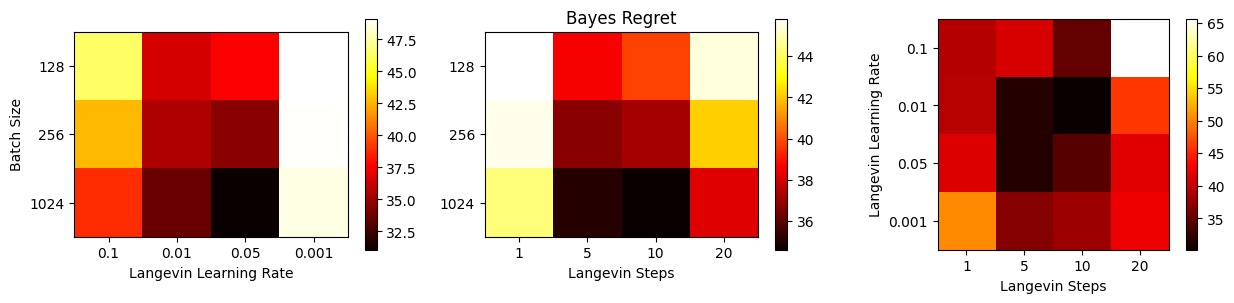

In [4]:
# plot results based on batch size, updates per step, and langevin learning rate
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
ax = axes[0]
ax.set_ylabel("Batch Size")
ax.set_xlabel("Langevin Learning Rate")
ax.set_xticks(range(len(langevin_learning_rates)))
ax.set_xticklabels(langevin_learning_rates)
ax.set_yticks(range(len(b_sizes)))
ax.set_yticklabels(b_sizes)
# ax.imshow(results.mean(axis=1), cmap='hot', interpolation='nearest')
# # add legend
cbar = ax.figure.colorbar(ax.imshow(results.mean(axis=1), cmap='hot', interpolation='nearest'))

ax = axes[1]
ax.set_title("Bayes Regret")
ax.set_xlabel("Langevin Steps")
ax.set_xticks(range(len(steps)))
ax.set_xticklabels(steps)
ax.set_yticks(range(len(b_sizes)))
ax.set_yticklabels(b_sizes)
# # add legend
cbar = ax.figure.colorbar(ax.imshow(results.mean(axis=2), cmap='hot', interpolation='nearest'))

ax = axes[2]
ax.set_ylabel("Langevin Learning Rate")
ax.set_xlabel("Langevin Steps")
ax.set_xticks(range(len(steps)))
ax.set_xticklabels(steps)
ax.set_yticks(range(len(langevin_learning_rates)))
ax.set_yticklabels(langevin_learning_rates)
# # add legend
cbar = ax.figure.colorbar(ax.imshow(results.mean(axis=0), cmap='hot', interpolation='nearest'))

plt.show()

In [5]:
indices = jnp.where(results == results.min())
logging.info(f"Best hyperparameters: batch: {b_sizes[indices[0][0]]}, langevin steps: {steps[indices[1][0]]}, learning rate: {langevin_learning_rates[indices[2][0]]}, regret: {results.min()}")

2024-01-24 20:44:02 INFO     Best hyperparameters: batch: 1024, langevin steps: 5, learning rate: 0.05000000074505806, regret: 26.98626136779785


## Hyerparameter Search - Max Entropy Thompson Sampling

In [6]:
NUM_ACTIONS = 5
NUM_STEPS = 1024
NUM_ENVS = 50
B_SIZE = 1024
UPDATES_PER_STEP = 5

MAX_ENT_LR = 1e-2
MAX_ENT_STEPS = 1000
MAX_ENT_SAMPLES = 1024
MAX_ENT_EPSILON = 1e-4
N_EXPERT_TRAJECTORY = 1000
SEED = 42
MAX_ENT_SEED = 712
EXPERT_TRAJ_SEED = 1233

# bernoulli bandit setup
action_space = spaces.Discrete(NUM_ACTIONS)
prior_function = jax.tree_util.Partial(lambda key, _: jax.random.uniform(key, shape=(NUM_ACTIONS,))) # uniform prior
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]).astype(jnp.float32))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
reward_mean_fn = jax.tree_util.Partial(lambda means, _, action: means[action])
mutli_armed_bandit = BayesStochasticBandit(action_space, prior_function, reward_dist_fn, reward_mean_fn, best_action_value_fn)

# search over langevin learning rate, batch size, and updates per step
feature_fn = jax.tree_util.Partial(lambda obs, action: jax.nn.one_hot(action, NUM_ACTIONS))

reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")

max_ent_ts_train = make_max_ent_thompson_sampling(env=mutli_armed_bandit,
                                          reward_model=reward_model,
                                          num_envs=NUM_ENVS,
                                          total_steps=NUM_STEPS,
                                          langevin_batch_size=B_SIZE,
                                          langevin_updates_per_step=UPDATES_PER_STEP,
                                          max_ent_prior_n_samples=MAX_ENT_SAMPLES,
                                          max_ent_steps=MAX_ENT_STEPS,)


expert_trajectories = generate_optimal_trajectories(jax.random.PRNGKey(EXPERT_TRAJ_SEED),
                                                    mutli_armed_bandit,
                                                    N_EXPERT_TRAJECTORY,
                                                    1,
                                                    None)

langevin_learning_rates = jnp.array([1e-2, 5e-2, 1e-3, 2.5e-4])
max_ent_lambdas = jnp.array([0.1, 1., 10., 50., 100.])
expert_betas = jnp.array([0.1, 1., 3., 10.])
env_rngs = jax.random.split(jax.random.PRNGKey(SEED), 5)

jit_max_ent_train_ts_hyper = jax.vmap(
  jax.vmap(
    jax.vmap(
      jax.vmap(jax.jit(max_ent_ts_train),
               in_axes=(None, None, None, None, None, None, None, 0)
      ),
      in_axes=(None, None, None, None, None, None, 0, None),
    ),
    in_axes=(None, None, None, None, 0, None, None, None)
  ),
  in_axes=(None, 0, None, None, None, None, None, None)
  )

jax.config.update("jax_disable_jit", False)

state, max_ent_state, hyper_metrics = jit_max_ent_train_ts_hyper(jax.random.PRNGKey(MAX_ENT_SEED),
                                                                  env_rngs,
                                                                  expert_trajectories,
                                                                  MAX_ENT_EPSILON,
                                                                  max_ent_lambdas,
                                                                  MAX_ENT_LR,
                                                                  expert_betas,
                                                                  langevin_learning_rates) # shape: (n_rngs, n_lambdas, n_betas, n_lrs, n_steps, n_envs ...)
bayes_regret = (hyper_metrics['optimal_value'] - hyper_metrics['reward_mean']).mean(axis=-1).sum(axis=-1).mean(axis=0) # shape: (n_lambdas, n_betas, n_lrs)

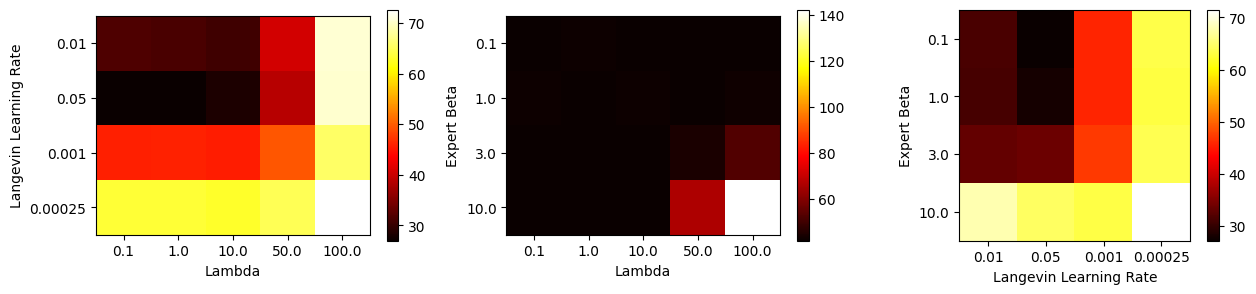

In [7]:
# plot results based on lambda, learning rate, and beta
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
ax = axes[0]
ax.set_ylabel("Langevin Learning Rate")
ax.set_xlabel("Lambda")
ax.set_xticks(range(len(max_ent_lambdas)))
ax.set_xticklabels(max_ent_lambdas)
ax.set_yticks(range(len(langevin_learning_rates)))
ax.set_yticklabels(langevin_learning_rates)
# # add legend
cbar = ax.figure.colorbar(ax.imshow(bayes_regret.mean(axis=1).T, cmap='hot', interpolation='nearest'))

ax = axes[1]
ax.set_ylabel("Expert Beta")
ax.set_xlabel("Lambda")
ax.set_xticks(range(len(max_ent_lambdas)))
ax.set_xticklabels(max_ent_lambdas)
ax.set_yticks(range(len(expert_betas)))
ax.set_yticklabels(expert_betas)
# ax.imshow(results.mean(axis=1), cmap='hot', interpolation='nearest')
# # add legend
cbar = ax.figure.colorbar(ax.imshow(bayes_regret.mean(axis=2).T, cmap='hot', interpolation='nearest'))

ax = axes[2]
ax.set_ylabel("Expert Beta")
ax.set_xlabel("Langevin Learning Rate")
ax.set_xticks(range(len(langevin_learning_rates)))
ax.set_xticklabels(langevin_learning_rates)
ax.set_yticks(range(len(expert_betas)))
ax.set_yticklabels(expert_betas)
# ax.imshow(results.mean(axis=1), cmap='hot', interpolation='nearest')
# # add legend
cbar = ax.figure.colorbar(ax.imshow(bayes_regret.mean(axis=0), cmap='hot', interpolation='nearest'))

plt.show()

## Final Hyperparams

In [8]:
MAX_ENT_LAMBDA = 1. # We might increase it for more complex envs
MAX_ENT_LR = 1e-2
MAX_ENT_STEPS = 1000
MAX_ENT_SAMPLES = 1024
MAX_ENT_EPSILON = 1e-4

EXPERT_BETA = 10.

LANGEVIN_B_SIZE = 1024
LANGEVIN_UPDATES_PER_STEP = 5
LANGEVIN_LEARNING_RATE = 0.05

# logging.info(f"Bayes regret for lambda: {MAX_ENT_LAMBDA}, langevin learning rate: {LANGEVIN_LEARNING_RATE}, expert beta: {EXPERT_BETA} is {bayes_regret[1,3,1]}")

## Expert Entropy and Episodes Effect

### Environment

In [9]:
NUM_ACTIONS = 8
NUM_ENVS = 256
NUM_STEPS = 1500
NUM_PRIORS = 512
EXPERT_N_TRAJECTORY = 1000
HORIZON = 1

ENV_SEED = 42
MAX_ENT_SEED = 512
SETTING_SEED = 2048

rng = PRNGSequence(SETTING_SEED)

alpha_betas = jax.random.beta(next(rng), 1. , 1. ,(NUM_PRIORS, NUM_ACTIONS, 2)) * 4

action_space = spaces.Discrete(NUM_ACTIONS)
def prior_function(key, i: Optional[int] = 0):
  return jax.random.beta(key, alpha_betas[i, :, 0], alpha_betas[i, :, 1])

prior_function = jax.tree_util.Partial(prior_function)
reward_dist_fn = jax.tree_util.Partial(lambda key, means, _, action: jax.random.bernoulli(key, means[action]).astype(jnp.float32))
best_action_value_fn = jax.tree_util.Partial(lambda means, _: (means.argmax(), means.max()))
reward_mean_fn = jax.tree_util.Partial(lambda means, _, action: means[action])
mutli_armed_bandit = BayesStochasticBandit(action_space, prior_function, reward_dist_fn, reward_mean_fn, best_action_value_fn)

### Generate Expert Trajectories

In [10]:

expert_trajectories = jax.vmap(generate_optimal_trajectories, in_axes=(None, None, None, None, 0))(
    next(rng), mutli_armed_bandit, EXPERT_N_TRAJECTORY, 1, jnp.arange(alpha_betas.shape[0])
)

In [11]:
# calculate the entropy of each expert trajectory
epsilon = 1e-8
entropy_fn = lambda exp_traj: - jax.vmap(lambda p: p * jnp.log2(p+epsilon))(jnp.bincount(exp_traj.action.flatten(), length=NUM_ACTIONS) / EXPERT_N_TRAJECTORY).sum()
expert_entropies = jax.vmap(entropy_fn)(expert_trajectories)


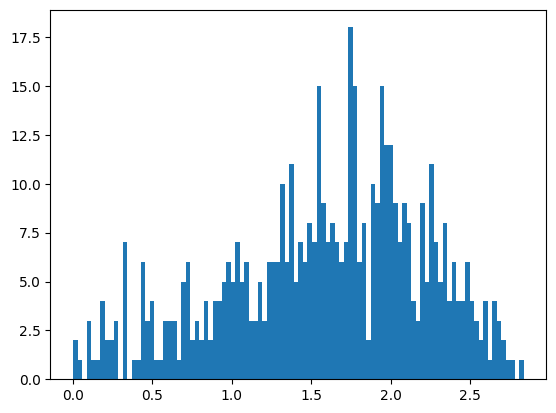

In [12]:
plt.hist(expert_entropies, bins=100)
plt.show()

### No Prior Thompson Sampling

In [13]:
jax.config.update("jax_disable_jit", False)

feature_fn = jax.tree_util.Partial(lambda obs, action: jax.nn.one_hot(action, NUM_ACTIONS))

reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")

ts_train = make_thompson_sampling(env=mutli_armed_bandit,
                                  reward_model=reward_model,
                                  num_envs = NUM_ENVS,
                                  total_steps=NUM_STEPS,
                                  langevin_batch_size=LANGEVIN_B_SIZE,
                                  langevin_updates_per_step=LANGEVIN_UPDATES_PER_STEP)

state, no_prior_metrics = jax.vmap(jax.jit(ts_train), in_axes=(None, None, 0))(
    jax.random.PRNGKey(ENV_SEED), LANGEVIN_LEARNING_RATE, jnp.arange(alpha_betas.shape[0])
)  # shape: (n_priors, n_steps, n_envs, ...)

no_prior_bayes_regret = (no_prior_metrics['optimal_value'] - no_prior_metrics['reward_mean']).mean(axis=-1).cumsum(axis=-1)

### True Prior Langevin Thompson Sampling

In [14]:
true_prior_log_pdf = jax.tree_util.Partial(lambda params, i: jax.scipy.stats.beta.logpdf(params['params']['param'], alpha_betas[i, :, 0], alpha_betas[i, :, 1]).sum(axis=-1))
reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")
langevin_true_prior_ts_train = make_thompson_sampling(env=mutli_armed_bandit,
                                                      reward_model=reward_model,
                                                      num_envs = NUM_ENVS,
                                                      total_steps=NUM_STEPS,
                                                      langevin_batch_size=LANGEVIN_B_SIZE,
                                                      langevin_updates_per_step=LANGEVIN_UPDATES_PER_STEP,
                                                      prior_log_pdf=true_prior_log_pdf)

state, langevin_true_prior_metrics = jax.vmap(jax.jit(langevin_true_prior_ts_train), in_axes=(None, None, 0))(
    jax.random.PRNGKey(ENV_SEED), LANGEVIN_LEARNING_RATE, jnp.arange(alpha_betas.shape[0])
)

langevin_true_bayes_regret = (langevin_true_prior_metrics['optimal_value'] - langevin_true_prior_metrics['reward_mean']).mean(axis=-1).cumsum(axis=-1)

### True Prior True Thompson Sampling

In [15]:
prior_alpha_betas = lambda i: alpha_betas[i, :, :]
true_prior_ts_train = make_bernoulli_thompson_sampling(env=mutli_armed_bandit,
                                                        num_envs = NUM_ENVS,
                                                        total_steps=NUM_STEPS,
                                                        prior_alpha_betas=prior_alpha_betas)

state, true_prior_metrics = jax.vmap(jax.jit(true_prior_ts_train), in_axes=(None, 0))(
    jax.random.PRNGKey(ENV_SEED), jnp.arange(alpha_betas.shape[0])
)

true_prior_bayes_regret = (true_prior_metrics['optimal_value'] - true_prior_metrics['reward_mean']).mean(axis=-1).cumsum(axis=-1)

### Max Entropy Thompson Sampling

In [16]:
from experior.bandit_agents import make_max_ent_thompson_sampling
jax.config.update("jax_disable_jit", False)
reward_model = LinearDiscreteRewardModel(n_actions=NUM_ACTIONS,
                                        params_dim=NUM_ACTIONS,
                                        feature_fn=feature_fn,
                                        dist="bernoulli")
max_ent_ts_train = make_max_ent_thompson_sampling(env=mutli_armed_bandit,
                                                  reward_model=reward_model,
                                                  num_envs=NUM_ENVS,
                                                  total_steps=NUM_STEPS,
                                                  langevin_batch_size=LANGEVIN_B_SIZE,
                                                  langevin_updates_per_step=LANGEVIN_UPDATES_PER_STEP,
                                                  max_ent_prior_n_samples=MAX_ENT_SAMPLES,
                                                  max_ent_steps=MAX_ENT_STEPS)
state, max_ent_state, max_ent_metrics = (
  jax.vmap(jax.jit(max_ent_ts_train), in_axes=(None, None, 0, None, None, None, None, None, 0))(
    jax.random.PRNGKey(MAX_ENT_SEED),
    jax.random.PRNGKey(ENV_SEED),
    expert_trajectories,
    MAX_ENT_EPSILON,
    MAX_ENT_LAMBDA,
    MAX_ENT_LR,
    EXPERT_BETA,
    LANGEVIN_LEARNING_RATE,
    jnp.arange(alpha_betas.shape[0])
)
)

In [ ]:
max_ent_bayes_regret = (max_ent_metrics['optimal_value'] - max_ent_metrics['reward_mean']).mean(axis=-1).cumsum(axis=-1)

## Plot the Results

In [12]:
# load the results if you don't want to run the experiments again
results = jnp.load("output/multi_armed_results.npz")
langevin_true_bayes_regret = results['langevin_true_bayes_regret']
no_prior_bayes_regret = results['no_prior_bayes_regret']
max_ent_bayes_regret = results['max_ent_bayes_regret']
expert_entropies = results['expert_entropies']

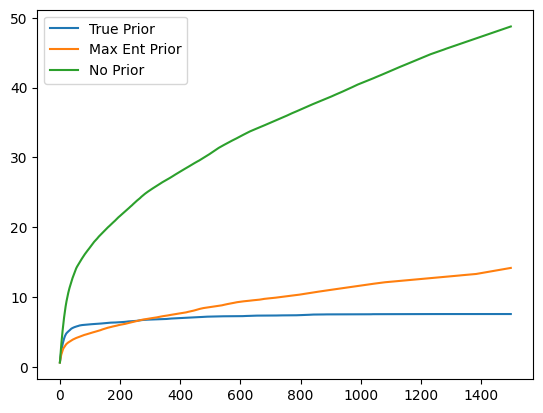

In [26]:
# detect outliers
indices = (langevin_true_bayes_regret[:, -1] <= no_prior_bayes_regret[:, -1]) & (langevin_true_bayes_regret[:, -1] <= max_ent_bayes_regret[:, -1])
expert_entropies = expert_entropies[indices]
langevin_true_bayes_regret = langevin_true_bayes_regret[indices]
no_prior_bayes_regret = no_prior_bayes_regret[indices]
max_ent_bayes_regret = max_ent_bayes_regret[indices]

plt.plot(langevin_true_bayes_regret[expert_entropies.argmin()], label="True Prior")
plt.plot(max_ent_bayes_regret[expert_entropies.argmin()], label="Max Ent Prior")
plt.plot(no_prior_bayes_regret[expert_entropies.argmin()], label="No Prior")
plt.legend()
plt.show()

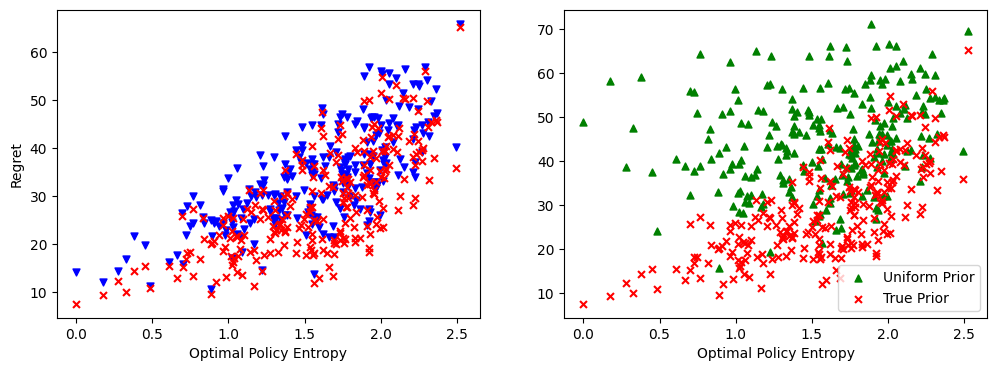

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
marker_size = 25

axis = axes[0]
axis.scatter(expert_entropies, max_ent_bayes_regret[:, -1], label="Max-Entropy Prior", s=marker_size, marker="v", c="blue")
axis.scatter(expert_entropies, langevin_true_bayes_regret[:, -1], label="True Prior", s=marker_size, marker="x", c="red")
axis.set_xlabel("Optimal Policy Entropy")
axis.set_ylabel("Regret")

axis = axes[1]
axis.scatter(expert_entropies, no_prior_bayes_regret[:, -1], label="Uniform Prior", s=marker_size, marker="^", c="green")
axis.scatter(expert_entropies, langevin_true_bayes_regret[:, -1], label="True Prior", s=marker_size, marker="x", c="red")
axis.set_xlabel("Optimal Policy Entropy")

plt.legend(loc="lower right")
plt.show()